<a href="https://colab.research.google.com/github/edermartelinho/MLP_de_2_e_L_Camadas/blob/main/MLP_2_e_L_camadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aprendizado Profundo
#Tema: MLP de 2 e $L$ camadas.

## Objetivos - integração de módulos.












### Importando bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py
import scipy
import os
from PIL import Image #biblioteca PIL (Python Imaging Library)
from scipy import ndimage
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
np.random.seed(1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py


def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy

    Arguments:
    Z -- numpy array of any shape

    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """

    A = 1/(1+np.exp(-Z))
    cache = Z

    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """

    A = np.maximum(0,Z)

    assert(A.shape == Z.shape)

    cache = Z
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.

    # When z <= 0, you should set dz to 0 as well.
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    Z = cache

    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)

    assert (dZ.shape == Z.shape)

    return dZ


def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer

    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """

    np.random.seed(1)

    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))

    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters


def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network

    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """

    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))


    return parameters

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """

    Z = W.dot(A) + b

    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """

    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation

    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()

    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network

    # Implemeipynbnt [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)

    assert(AL.shape == (1,X.shape[1]))

    return AL, caches

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """

    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))

    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())

    return cost

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.

    Arguments:
    dA -- post-activation gradient for current layer l
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group

    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)

    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ...
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ...
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")

    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent

    Arguments:
    parameters -- python dictionary containing your parameters
    grads -- python dictionary containing your gradients, output of L_model_backward

    Returns:
    parameters -- python dictionary containing your updated parameters
                  parameters["W" + str(l)] = ...
                  parameters["b" + str(l)] = ...
    """

    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.

    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model

    Returns:
    p -- predictions for the given dataset X
    """

    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))

    # Forward propagation
    probas, caches = L_model_forward(X, parameters)


    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))

    return p

def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]

        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

### Montando o Google Drive no Colab para ter acesso aos arquivos armazenados lá.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Listar as pastas onde as imagens estão.

In [ ]:
import os

diretorios = os.listdir('/content/drive/MyDrive/CatAndDog,Elefante')
print(diretorios)


#diretorios=os.listdir('/content/drive/MyDrive/Datasets/CatAndDog')
#print(diretorios)

['Cachorro', 'Gato', 'Elefante', '.ipynb_checkpoints']


### Definindo os caminhos (paths) das pastas onde os arquivos estão.

In [ ]:
classe_0_path = '/content/drive/MyDrive/CatAndDog,Elefante/Elefante'
classe_1_path = '/content/drive/MyDrive/CatAndDog,Elefante/Gato'

### Função para carregar as imagens

In [ ]:
def load_images_from_folder(folder, label, image_size=(64, 64)):
    images = []
    labels = []

    # Listar todos os arquivos no diretório
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)

        # Abrir a imagem
        img = Image.open(img_path).convert('RGB') # Garante que todas as imagens serão convertidas para RGB

        # Redimensionar a imagem para o tamanho desejado (224x224)
        img = img.resize(image_size)

        # Converter para array NumPy
        img_array = np.array(img)

        # Adicionar a imagem e o rótulo à lista
        images.append(img_array)
        labels.append(label)

    return np.array(images), np.array(labels)

### Carregando as imagens de ambas as classes e os seus respectivos rótulos e conferindo as dimensões

In [ ]:
# Carregar as imagens de ambas as classes
images_classe_0, labels_classe_0 = load_images_from_folder(classe_0_path, label=0)
images_classe_1, labels_classe_1 = load_images_from_folder(classe_1_path, label=1)

# Concatenar as imagens e os rótulos
images = np.concatenate((images_classe_0, images_classe_1), axis=0)
labels = np.concatenate((labels_classe_0, labels_classe_1), axis=0)

#Usando a função "reshape" para evitar array de rank 1. Isso evita vários problemas com vetores e matrizes e já transpõe o vetor dos rótulos.
labels_transp=labels.reshape(1,labels.shape[0])

# Verificar as dimensões dos arrays
print("Formato das imagens:", images.shape)  # (total_imagens, altura, largura, canais)
print("Formato dos rótulos:", labels_transp.shape)  # (1,total_imagens)


Formato das imagens: (290, 64, 64, 3)
Formato dos rótulos: (1, 290)


### Visualizando uma imagem do *dataset*
#### (Human => index=[0,149] e Gato => index=[150,299])

y = [1], isto é a imagem de um Gato


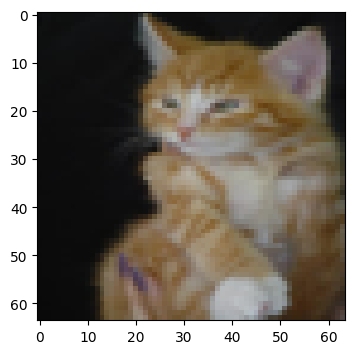

In [ ]:
index = 153
plt.imshow(images[index])
arr=labels_transp[:,index]
valor=arr[0]
if valor==0:
  print ("y = " + str(labels_transp[:, index]) + ", isto é a imagem de um Human")
else:
  print ("y = " + str(labels_transp[:, index]) + ", isto é a imagem de um Gato")

### Separando o *dataset* nos subconjuntos de treinamento (train) e teste (test).

In [ ]:
#Renomeando as entradas (para X) e os rótulos (para y)
X=images
y=labels

#Separando em subconjuntos de treinamento e teste
X_train_orig, X_test_orig, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True)



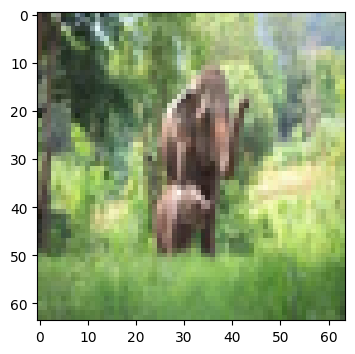

In [ ]:
# Só para verificar a integridade da amostragem
index = 4
plt.imshow(X_train_orig[index])

### Usando a função reshape para evitar problemas com rank 1 e para transpor os vetores dos rótulos

In [ ]:
y_train=y_train.reshape(1,y_train.shape[0])
y_test=y_test.reshape(1,y_test.shape[0])

### Verificando as dimensões das matrizes e vetores

In [ ]:
#Extraindo as dimensões
m_train = X_train_orig.shape[0]
m_test = X_test_orig.shape[0]
num_px = X_train_orig.shape[1]

#Imprimindo os resultados para conferir as dimensões.
print ("Número de objetos do conjunto de treinamento: m_train = " + str(m_train))
print ("Número de objetos do conjunto de teste: m_test = " + str(m_test))
print ("Altura/largura de cada imagem: num_px = " + str(num_px))
print ("Dimensões das imagens: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("X_train_orig shape: " + str(X_train_orig.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_test_orig shape: " + str(X_test_orig.shape))
print ("y_test shape: " + str(y_test.shape))

Número de objetos do conjunto de treinamento: m_train = 203
Número de objetos do conjunto de teste: m_test = 87
Altura/largura de cada imagem: num_px = 64
Dimensões das imagens: (64, 64, 3)
X_train_orig shape: (203, 64, 64, 3)
y_train shape: (1, 203)
X_test_orig shape: (87, 64, 64, 3)
y_test shape: (1, 87)


### "Achatamento" (*flattening*) das imagens: transformar cada imagem que está em formato matricial (num_pix, num_pix, 3) em um vetor (num_pix \* num_pix \* 3,1). Isto deve ser feito diretamente nos tensores X_train_orig e X_test_orig.

In [ ]:
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
print ("X_train_flatten shape: " + str(X_train_flatten.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_test_flatten shape: " + str(X_test_flatten.shape))
print ("y_test shape: " + str(y_test.shape))
#print ("Sanity check after reshaping: " + str(X_train_flatten[0:5,0])) #Checar essa linha
#print("The first 5 values ​​of the first row of the matrix: " + str(X_train_orig[0, 0, 0:5, 0])) #Checa os cinco primeiros pixels do canal R (0) da primeira imagem

X_train_flatten shape: (12288, 203)
y_train shape: (1, 203)
X_test_flatten shape: (12288, 87)
y_test shape: (1, 87)


### Preprocessamento do *dataset*: apesar da normalização ser comumente utilizada em aprendizado de máquina, para imagens é suficiente dividir pelo valor máximo de cada pixel (255).

In [ ]:
train_x = X_train_flatten/255
test_x = X_test_flatten/255

In [ ]:
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 203)
test_x's shape: (12288, 87)


### Hiperparâmatros e constantes do modelo

In [ ]:
n_x = train_x.shape[0] # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
print(n_x)

12288


### Modelo de 2 camadas

In [ ]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations =3000, print_cost=False):

    np.random.seed(1)
    grads = {}
    costs = [] # to keep track of the cost
    m = X.shape[1] # number of examples
    (n_x, n_h, n_y) = layers_dims


    parameters = initialize_parameters(n_x, n_h, n_y)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    #loop Gradiente Descendente
    for i in range(0, num_iterations):

        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")

        cost = compute_cost(A2, Y)

        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")

        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2

        parameters = update_parameters(parameters, grads, learning_rate)

        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]

        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

#### Treinando o modelo

Cost after iteration 0: 0.6931661908742652
Cost after iteration 100: 0.6847644968983286
Cost after iteration 200: 0.6357380291138953
Cost after iteration 300: 0.5492766050243325
Cost after iteration 400: 0.4613108836967984
Cost after iteration 500: 0.3803425709027414
Cost after iteration 600: 0.3070130214306668
Cost after iteration 700: 0.3172809130851467
Cost after iteration 800: 0.27010857967709184
Cost after iteration 900: 0.23560178176597327
Cost after iteration 1000: 0.15395473384215738
Cost after iteration 1100: 0.11234313122608464
Cost after iteration 1200: 0.09072582744995605
Cost after iteration 1300: 0.07388326166356703
Cost after iteration 1400: 0.06093321330511301
Cost after iteration 1500: 0.05100303006250404
Cost after iteration 1600: 0.043261671209967
Cost after iteration 1700: 0.037164599537154286
Cost after iteration 1800: 0.03228980550407385
Cost after iteration 1900: 0.028356104416709393
Cost after iteration 2000: 0.025124352112242884
Cost after iteration 2100: 0.022

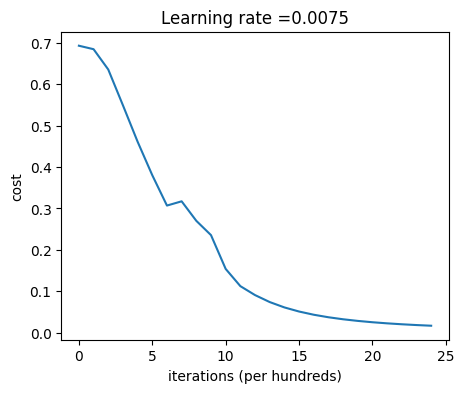

In [ ]:
parameters = two_layer_model(train_x, y_train, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

#### Calculando predições para o conjunto de treinamento

In [ ]:
predictions_train = predict(train_x, y_train, parameters)

Accuracy: 1.0


#### Calculando predições para o conjunto de teste

In [ ]:
predictions_test = predict(test_x, y_test, parameters)

Accuracy: 0.6781609195402298


### Modelo de $L$ Camadas

#### Definindo o número de neurônios das camadas

In [ ]:
layers_dims = [train_x.shape[0], 20, 7, 5, 1] # 4-layer model

#### Integrando os módulos do modelo

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009

    np.random.seed(1)
    costs = [] # keep track of cost

    parameters = initialize_parameters_deep(layers_dims)

# Loop (gradient descent)
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)

        cost = compute_cost(AL, Y)

        grads = L_model_backward(AL, Y, caches)

        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
# plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

#### Treinando o modelo

Cost after iteration 0: 0.700576
Cost after iteration 100: 0.526892
Cost after iteration 200: 0.442004
Cost after iteration 300: 0.413597
Cost after iteration 400: 0.350587
Cost after iteration 500: 0.298672
Cost after iteration 600: 0.258553
Cost after iteration 700: 0.217185
Cost after iteration 800: 0.188612
Cost after iteration 900: 0.166959
Cost after iteration 1000: 0.150098
Cost after iteration 1100: 0.136313
Cost after iteration 1200: 0.122149
Cost after iteration 1300: 0.111697
Cost after iteration 1400: 0.103210
Cost after iteration 1500: 0.094724
Cost after iteration 1600: 0.086019
Cost after iteration 1700: 0.079178
Cost after iteration 1800: 0.072464
Cost after iteration 1900: 0.067494
Cost after iteration 2000: 0.061723
Cost after iteration 2100: 0.058078
Cost after iteration 2200: 0.055736
Cost after iteration 2300: 0.050276
Cost after iteration 2400: 0.047496


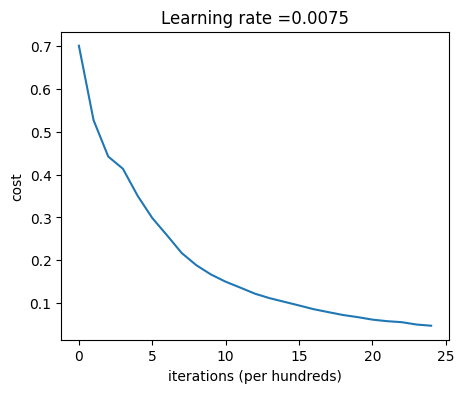

In [ ]:
parameters = L_layer_model(train_x, y_train, layers_dims, num_iterations = 2500, print_cost = True)

#### Calculando acurácia para o conjunto de treinamento

In [ ]:
pred_train = predict(train_x, y_train, parameters)

Accuracy: 1.0


#### Calculando acurácia para o conjunto de teste

In [ ]:
pred_test = predict(test_x, y_test, parameters)

Accuracy: 0.6781609195402297
